## Crypto Prediction with LSTM: BitCoin (BTC)

- This notebook attempts to use TensorFlow Keras LSTM to predict movement in Crypto prices
- Data is pulled from the CoinApi, so it can be refreshed at any point and retrained
- 2 optimizations were used and an overall R2 score of .86 was attained

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
import json
import tensorflow as tf
from copy import deepcopy as dc
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import *
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from tensorflow.keras.optimizers import Adam
import datetime as dt

import nasdaqdatalink

from api_keys import coinapi_key

2023-09-19 12:03:58.358596: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
#  https://docs.coinapi.io/market-data/rest-api/ohlcv
# Pull ETH data from coinapi

url = 'https://rest.coinapi.io/v1/ohlcv/BITSTAMP_SPOT_BTC_USD/history?period_id=1DAY&limit=20000'
headers = {'X-CoinAPI-Key' : coinapi_key}
response = requests.get(url, headers=headers)
 
if response.status_code == 200:
    json_data = response.json()
    print(json_data)
else:
    print(f"Error: {response.status_code}")

[{'time_period_start': '2023-09-19T00:00:00.0000000Z', 'time_period_end': '2023-09-20T00:00:00.0000000Z', 'time_open': '2023-09-19T00:00:46.8100000Z', 'time_close': '2023-09-19T16:04:58.9410000Z', 'price_open': 26766, 'price_high': 27484, 'price_low': 26682, 'price_close': 27399, 'volume_traded': 1353.20937979, 'trades_count': 8888}, {'time_period_start': '2023-09-18T00:00:00.0000000Z', 'time_period_end': '2023-09-19T00:00:00.0000000Z', 'time_open': '2023-09-18T00:00:10.5790000Z', 'time_close': '2023-09-18T23:59:38.3520000Z', 'price_open': 26533, 'price_high': 27421, 'price_low': 26382, 'price_close': 26770, 'volume_traded': 1942.69872335, 'trades_count': 13118}, {'time_period_start': '2023-09-17T00:00:00.0000000Z', 'time_period_end': '2023-09-18T00:00:00.0000000Z', 'time_open': '2023-09-17T00:00:28.1100000Z', 'time_close': '2023-09-17T23:59:20.7440000Z', 'price_open': 26571, 'price_high': 26618, 'price_low': 26414, 'price_close': 26535, 'volume_traded': 529.80823767, 'trades_count': 7

In [3]:
#Convert json to pandas df
df = pd.DataFrame(json_data)

df.head()

,time_period_start,time_period_end,time_open,time_close,price_open,price_high,price_low,price_close,volume_traded,trades_count
0,2023-09-19T00:00:00.0000000Z,2023-09-20T00:00:00.0000000Z,2023-09-19T00:00:46.8100000Z,2023-09-19T16:04:58.9410000Z,26766.0,27484.0,26682.0,27399.0,1353.209380,8888
1,2023-09-18T00:00:00.0000000Z,2023-09-19T00:00:00.0000000Z,2023-09-18T00:00:10.5790000Z,2023-09-18T23:59:38.3520000Z,26533.0,27421.0,26382.0,26770.0,1942.698723,13118
2,2023-09-17T00:00:00.0000000Z,2023-09-18T00:00:00.0000000Z,2023-09-17T00:00:28.1100000Z,2023-09-17T23:59:20.7440000Z,26571.0,26618.0,26414.0,26535.0,529.808238,7247
3,2023-09-16T00:00:00.0000000Z,2023-09-17T00:00:00.0000000Z,2023-09-16T00:00:06.6310000Z,2023-09-16T23:59:36.1270000Z,26609.0,26767.0,26459.0,26571.0,602.340303,7658
4,2023-09-15T00:00:00.0000000Z,2023-09-16T00:00:00.0000000Z,2023-09-15T00:00:32.9490000Z,2023-09-15T23:59:45.8940000Z,26529.0,26878.0,26228.0,26607.0,1379.105636,11902


In [4]:
#reduce df to x and y columns
data = df[["time_period_start", "price_close"]]

#rename columns
data = data.rename(columns={"time_period_start":"Date","price_close":"Close"})

#convert date to dt, refomat to yyyymmdd
data['Date'] = pd.to_datetime(data['Date']).dt.date

#json return began with most recent date, reversed for plotting/analysis
data = data.reindex(index=data.index[::-1])

#set date as index
data.set_index('Date', inplace=True)

data.head()

,Close
Date,
2011-09-13,5.97
2011-09-14,5.53
2011-09-15,5.13
2011-09-16,4.85
2011-09-17,4.87


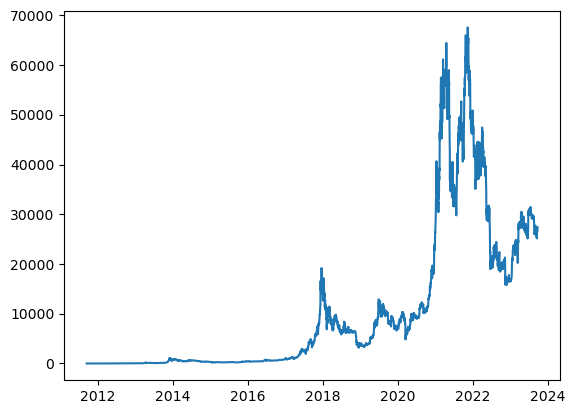

In [5]:
#plot historical amzn price
plt.plot(data)

In [6]:
# Set parameters for model

lookback = 7

split_1 = .8
split_2 = .9

In [7]:
# build lookback for lstm training
def prepare_dataframe_for_lstm(data, n_steps):
    data = dc(data)
    
    for i in range(1, n_steps+1):
        data[f'Close(t-{i})'] = data['Close'].shift(i)
        
    data.dropna(inplace=True)
    
    return data

shifted_df = prepare_dataframe_for_lstm(data, lookback)

# name date column from new index (since start date is absorbed into first x windows)
dates = shifted_df.index

#convert from df to numpy array
shifted_df_as_np = shifted_df.to_numpy()

#Scale data
log_transformed_data = np.log(shifted_df_as_np)



# split reference from deatures
X1 = log_transformed_data[:, 1:]
y1 = log_transformed_data[:, 0]

#flip order of windows (needs to start with most recent)

X1 = dc(np.flip(X1, axis=1))
X1


X1.shape, y1.shape, dates.shape


((4230, 7), (4230,), (4230,))

In [8]:
#Calculate split points based on previously defined variables
train_split = int(len(X1) * split_1)
test_split = int(len(X1) * split_2)

#Define spilt points for train/val/test
dates_train1, X_train1, y_train1 = dates[:train_split],X1[:train_split], y1[:train_split]
dates_val1, X_val1, y_val1 = dates[train_split:test_split], X1[train_split:test_split], y1[train_split:test_split]
dates_test1, X_test1, y_test1 = dates[test_split:], X1[test_split:], y1[test_split:]
X_train1.shape, y_train1.shape, X_val1.shape, y_val1.shape, X_test1.shape, y_test1.shape

((3384, 7), (3384,), (423, 7), (423,), (423, 7), (423,))

In [9]:
#Build, compile, fit LSTM model

model = Sequential([layers.Input((lookback, 1)),
                    layers.LSTM(64),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(1)])

model.compile(loss='mse',
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_error'])

model.fit(X_train1, y_train1, validation_data=(X_val1, y_val1), epochs=100)

2023-09-19 12:05:10.663170: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/100
106/106 [==============================] - 5s 27ms/step - loss: 10.8916 - mean_absolute_error: 2.1104 - val_loss: 0.1505 - val_mean_absolute_error: 0.3681
Epoch 2/100
106/106 [==============================] - 1s 7ms/step - loss: 0.0084 - mean_absolute_error: 0.0601 - val_loss: 0.0283 - val_mean_absolute_error: 0.1536
Epoch 3/100
106/106 [==============================] - 1s 10ms/step - loss: 0.0060 - mean_absolute_error: 0.0561 - val_loss: 0.0069 - val_mean_absolute_error: 0.0661
Epoch 4/100
106/106 [==============================] - 1s 7ms/step - loss: 0.0049 - mean_absolute_error: 0.0486 - val_loss: 0.0055 - val_mean_absolute_error: 0.0607
Epoch 5/100
106/106 [==============================] - 1s 8ms/step - loss: 0.0045 - mean_absolute_error: 0.0458 - val_loss: 0.0048 - val_mean_absolute_error: 0.0541
Epoch 6/100
106/106 [==============================] - 1s 11ms/step - loss: 0.0051 - mean_absolute_error: 0.0501 - val_loss: 0.0037 - val_mean_absolute_error: 0.0468
Epoch 

106/106 [==============================] - 1s 8ms/step - loss: 0.0033 - mean_absolute_error: 0.0379 - val_loss: 0.0033 - val_mean_absolute_error: 0.0461
Epoch 51/100
106/106 [==============================] - 1s 7ms/step - loss: 0.0031 - mean_absolute_error: 0.0372 - val_loss: 0.0019 - val_mean_absolute_error: 0.0346
Epoch 52/100
106/106 [==============================] - 1s 10ms/step - loss: 0.0035 - mean_absolute_error: 0.0403 - val_loss: 0.0030 - val_mean_absolute_error: 0.0456
Epoch 53/100
106/106 [==============================] - 1s 8ms/step - loss: 0.0035 - mean_absolute_error: 0.0407 - val_loss: 0.0035 - val_mean_absolute_error: 0.0486
Epoch 54/100
106/106 [==============================] - 1s 8ms/step - loss: 0.0035 - mean_absolute_error: 0.0405 - val_loss: 0.0055 - val_mean_absolute_error: 0.0660
Epoch 55/100
106/106 [==============================] - 1s 8ms/step - loss: 0.0050 - mean_absolute_error: 0.0521 - val_loss: 0.0018 - val_mean_absolute_error: 0.0338
Epoch 56/100
106

106/106 [==============================] - 1s 7ms/step - loss: 0.0032 - mean_absolute_error: 0.0388 - val_loss: 0.0018 - val_mean_absolute_error: 0.0316
Epoch 100/100
106/106 [==============================] - 1s 7ms/step - loss: 0.0031 - mean_absolute_error: 0.0372 - val_loss: 0.0024 - val_mean_absolute_error: 0.0402


106/106 [==============================] - 1s 2ms/step


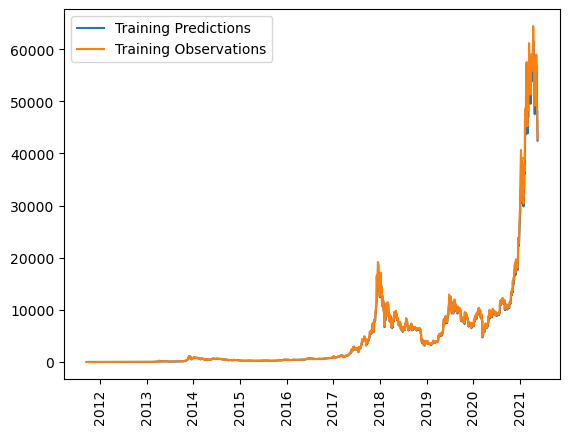

In [10]:
# Check training predictions (use np.exp to transform scaled data back to original scale)

train_predictions = model.predict(X_train1).flatten()

plt.plot(dates_train1, np.exp(train_predictions))
plt.plot(dates_train1, np.exp(y_train1))
plt.xticks(rotation=90)
plt.legend(['Training Predictions', 'Training Observations'])

In [11]:
# Check scores for val period
score = model.evaluate(X_val1, y_val1, verbose = 0) 

print('Val loss:', score[0]) 
print('Val MAE:', score[1])

Val loss: 0.00242306524887681
Val MAE: 0.04024219885468483


14/14 [==============================] - 0s 2ms/step


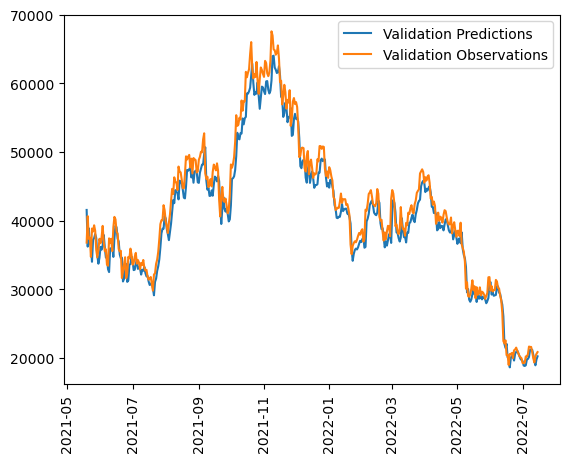

In [12]:
# graphed performance of val data in model
val_predictions = model.predict(X_val1).flatten()

plt.plot(dates_val1, np.exp(val_predictions))
plt.plot(dates_val1, np.exp(y_val1))
plt.xticks(rotation=90)
plt.legend(['Validation Predictions', 'Validation Observations'])

In [13]:
score = model.evaluate(X_test1, y_test1, verbose = 0) 

print('Test loss:', score[0]) 
print('Test MAE:', score[1])

Test loss: 0.0011793874436989427
Test MAE: 0.02697654440999031


14/14 [==============================] - 0s 3ms/step


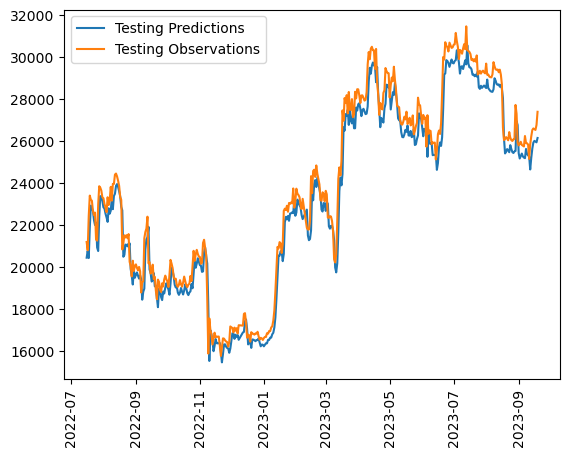

In [14]:
#check model against test data
test_predictions = model.predict(X_test1).flatten()

plt.plot(dates_test1, np.exp(test_predictions))
plt.plot(dates_test1, np.exp(y_test1))
plt.xticks(rotation=90)
plt.legend(['Testing Predictions', 'Testing Observations'])

In [15]:
# Check r2 score
print('R2 Score: ', r2_score(y_test1, test_predictions))

R2 Score:  0.9687440959825682


## Optimization of the Model

- Adjust the initial data used, limited to the last 50% of the data
- Focus more on recent trends for learning
- Increase Epochs
- Slow learning rate

In [16]:
# Split is changed to begin at 50% of the dataset and continue to the end.
split_1 = .5
split_2 = .89
split_3 = .95


initial_split = int(len(X1) * split_1)
train_split = int(len(X1) * split_2)
test_split = int(len(X1) * split_3)

In [17]:
#change timeframe

dates_train2, X_train2, y_train2 = dates[initial_split:train_split],X1[initial_split:train_split], y1[initial_split:train_split]
dates_val2, X_val2, y_val2 = dates[train_split:test_split], X1[train_split:test_split], y1[train_split:test_split]
dates_test2, X_test2, y_test2 = dates[test_split:], X1[test_split:], y1[test_split:]
dates_train2.shape, X_train2.shape, y_train2.shape, \
dates_val2.shape, X_val2.shape, y_val2.shape, \
dates_test2.shape, X_test2.shape, y_test2.shape

((1649,),
 (1649, 7),
 (1649,),
 (254,),
 (254, 7),
 (254,),
 (212,),
 (212, 7),
 (212,))

In [18]:
# Build, compile and fit the new model- increased epochs, smaller learning rate
model2 = Sequential([layers.Input((lookback, 1)),
                    layers.LSTM(64),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(1)])

model2.compile(loss='mse',
              optimizer=Adam(learning_rate=0.0001),
              metrics=['mean_absolute_error'])

model2.fit(X_train1, y_train1, validation_data=(X_val1, y_val1), epochs=300)

Epoch 1/300
106/106 [==============================] - 4s 15ms/step - loss: 45.5091 - mean_absolute_error: 6.2813 - val_loss: 88.2500 - val_mean_absolute_error: 9.3901
Epoch 2/300
106/106 [==============================] - 1s 7ms/step - loss: 25.9288 - mean_absolute_error: 4.5338 - val_loss: 43.8021 - val_mean_absolute_error: 6.6121
Epoch 3/300
106/106 [==============================] - 1s 10ms/step - loss: 6.5259 - mean_absolute_error: 2.0610 - val_loss: 14.1106 - val_mean_absolute_error: 3.7453
Epoch 4/300
106/106 [==============================] - 1s 12ms/step - loss: 1.9515 - mean_absolute_error: 1.1885 - val_loss: 7.0463 - val_mean_absolute_error: 2.6409
Epoch 5/300
106/106 [==============================] - 1s 8ms/step - loss: 0.6124 - mean_absolute_error: 0.6061 - val_loss: 2.9965 - val_mean_absolute_error: 1.7135
Epoch 6/300
106/106 [==============================] - 1s 6ms/step - loss: 0.1586 - mean_absolute_error: 0.2490 - val_loss: 1.2444 - val_mean_absolute_error: 1.0911
Ep

106/106 [==============================] - 1s 7ms/step - loss: 0.0045 - mean_absolute_error: 0.0448 - val_loss: 0.0055 - val_mean_absolute_error: 0.0585
Epoch 51/300
106/106 [==============================] - 1s 6ms/step - loss: 0.0043 - mean_absolute_error: 0.0429 - val_loss: 0.0057 - val_mean_absolute_error: 0.0599
Epoch 52/300
106/106 [==============================] - 1s 7ms/step - loss: 0.0043 - mean_absolute_error: 0.0435 - val_loss: 0.0035 - val_mean_absolute_error: 0.0465
Epoch 53/300
106/106 [==============================] - 1s 7ms/step - loss: 0.0043 - mean_absolute_error: 0.0426 - val_loss: 0.0059 - val_mean_absolute_error: 0.0608
Epoch 54/300
106/106 [==============================] - 1s 7ms/step - loss: 0.0044 - mean_absolute_error: 0.0440 - val_loss: 0.0062 - val_mean_absolute_error: 0.0629
Epoch 55/300
106/106 [==============================] - 1s 7ms/step - loss: 0.0043 - mean_absolute_error: 0.0432 - val_loss: 0.0035 - val_mean_absolute_error: 0.0461
Epoch 56/300
106/

106/106 [==============================] - 1s 6ms/step - loss: 0.0035 - mean_absolute_error: 0.0387 - val_loss: 0.0026 - val_mean_absolute_error: 0.0396
Epoch 100/300
106/106 [==============================] - 1s 6ms/step - loss: 0.0034 - mean_absolute_error: 0.0370 - val_loss: 0.0025 - val_mean_absolute_error: 0.0390
Epoch 101/300
106/106 [==============================] - 1s 6ms/step - loss: 0.0035 - mean_absolute_error: 0.0382 - val_loss: 0.0039 - val_mean_absolute_error: 0.0484
Epoch 102/300
106/106 [==============================] - 1s 6ms/step - loss: 0.0035 - mean_absolute_error: 0.0385 - val_loss: 0.0027 - val_mean_absolute_error: 0.0396
Epoch 103/300
106/106 [==============================] - 1s 6ms/step - loss: 0.0036 - mean_absolute_error: 0.0396 - val_loss: 0.0030 - val_mean_absolute_error: 0.0423
Epoch 104/300
106/106 [==============================] - 1s 6ms/step - loss: 0.0034 - mean_absolute_error: 0.0377 - val_loss: 0.0031 - val_mean_absolute_error: 0.0432
Epoch 105/30

106/106 [==============================] - 1s 11ms/step - loss: 0.0030 - mean_absolute_error: 0.0345 - val_loss: 0.0028 - val_mean_absolute_error: 0.0408
Epoch 149/300
106/106 [==============================] - 1s 7ms/step - loss: 0.0030 - mean_absolute_error: 0.0347 - val_loss: 0.0020 - val_mean_absolute_error: 0.0350
Epoch 150/300
106/106 [==============================] - 1s 6ms/step - loss: 0.0030 - mean_absolute_error: 0.0348 - val_loss: 0.0022 - val_mean_absolute_error: 0.0351
Epoch 151/300
106/106 [==============================] - 1s 6ms/step - loss: 0.0029 - mean_absolute_error: 0.0341 - val_loss: 0.0021 - val_mean_absolute_error: 0.0342
Epoch 152/300
106/106 [==============================] - 1s 6ms/step - loss: 0.0031 - mean_absolute_error: 0.0362 - val_loss: 0.0027 - val_mean_absolute_error: 0.0406
Epoch 153/300
106/106 [==============================] - 1s 6ms/step - loss: 0.0029 - mean_absolute_error: 0.0332 - val_loss: 0.0024 - val_mean_absolute_error: 0.0369
Epoch 154/3

106/106 [==============================] - 1s 6ms/step - loss: 0.0028 - mean_absolute_error: 0.0337 - val_loss: 0.0022 - val_mean_absolute_error: 0.0351
Epoch 198/300
106/106 [==============================] - 1s 6ms/step - loss: 0.0029 - mean_absolute_error: 0.0347 - val_loss: 0.0017 - val_mean_absolute_error: 0.0305
Epoch 199/300
106/106 [==============================] - 1s 6ms/step - loss: 0.0027 - mean_absolute_error: 0.0331 - val_loss: 0.0025 - val_mean_absolute_error: 0.0386
Epoch 200/300
106/106 [==============================] - 1s 6ms/step - loss: 0.0027 - mean_absolute_error: 0.0327 - val_loss: 0.0019 - val_mean_absolute_error: 0.0327
Epoch 201/300
106/106 [==============================] - 1s 6ms/step - loss: 0.0027 - mean_absolute_error: 0.0329 - val_loss: 0.0041 - val_mean_absolute_error: 0.0529
Epoch 202/300
106/106 [==============================] - 1s 6ms/step - loss: 0.0029 - mean_absolute_error: 0.0348 - val_loss: 0.0017 - val_mean_absolute_error: 0.0317
Epoch 203/30

106/106 [==============================] - 1s 6ms/step - loss: 0.0027 - mean_absolute_error: 0.0333 - val_loss: 0.0024 - val_mean_absolute_error: 0.0375
Epoch 247/300
106/106 [==============================] - 1s 6ms/step - loss: 0.0028 - mean_absolute_error: 0.0341 - val_loss: 0.0030 - val_mean_absolute_error: 0.0431
Epoch 248/300
106/106 [==============================] - 1s 6ms/step - loss: 0.0027 - mean_absolute_error: 0.0330 - val_loss: 0.0026 - val_mean_absolute_error: 0.0400
Epoch 249/300
106/106 [==============================] - 1s 6ms/step - loss: 0.0027 - mean_absolute_error: 0.0321 - val_loss: 0.0016 - val_mean_absolute_error: 0.0290
Epoch 250/300
106/106 [==============================] - 1s 6ms/step - loss: 0.0027 - mean_absolute_error: 0.0327 - val_loss: 0.0023 - val_mean_absolute_error: 0.0374
Epoch 251/300
106/106 [==============================] - 1s 6ms/step - loss: 0.0026 - mean_absolute_error: 0.0318 - val_loss: 0.0016 - val_mean_absolute_error: 0.0305
Epoch 252/30

106/106 [==============================] - 1s 7ms/step - loss: 0.0027 - mean_absolute_error: 0.0336 - val_loss: 0.0034 - val_mean_absolute_error: 0.0480
Epoch 296/300
106/106 [==============================] - 1s 6ms/step - loss: 0.0026 - mean_absolute_error: 0.0321 - val_loss: 0.0016 - val_mean_absolute_error: 0.0294
Epoch 297/300
106/106 [==============================] - 1s 6ms/step - loss: 0.0027 - mean_absolute_error: 0.0328 - val_loss: 0.0017 - val_mean_absolute_error: 0.0297
Epoch 298/300
106/106 [==============================] - 1s 6ms/step - loss: 0.0028 - mean_absolute_error: 0.0340 - val_loss: 0.0026 - val_mean_absolute_error: 0.0419
Epoch 299/300
106/106 [==============================] - 1s 7ms/step - loss: 0.0028 - mean_absolute_error: 0.0351 - val_loss: 0.0016 - val_mean_absolute_error: 0.0288
Epoch 300/300
106/106 [==============================] - 1s 6ms/step - loss: 0.0026 - mean_absolute_error: 0.0316 - val_loss: 0.0016 - val_mean_absolute_error: 0.0288


52/52 [==============================] - 1s 3ms/step


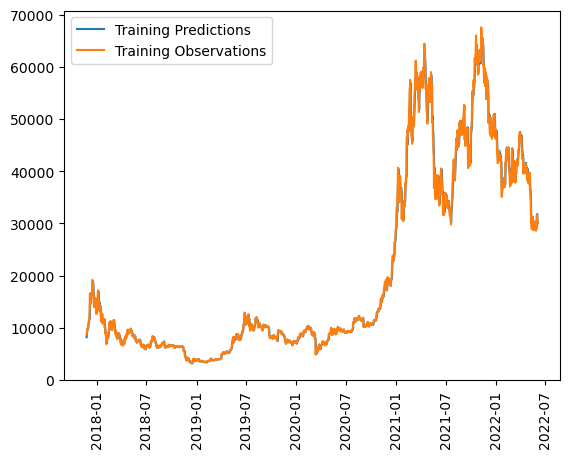

In [19]:
#Second model observations
train_predictions2 = model2.predict(X_train2).flatten()

plt.plot(dates_train2, np.exp(train_predictions2))
plt.plot(dates_train2, np.exp(y_train2))
plt.xticks(rotation=90)
plt.legend(['Training Predictions', 'Training Observations'])

In [20]:
score = model2.evaluate(X_val2, y_val2, verbose = 0) 

print('Val loss:', score[0]) 
print('Val MAE:', score[1])

Val loss: 0.0011084253201261163
Val MAE: 0.021358080208301544


8/8 [==============================] - 0s 4ms/step


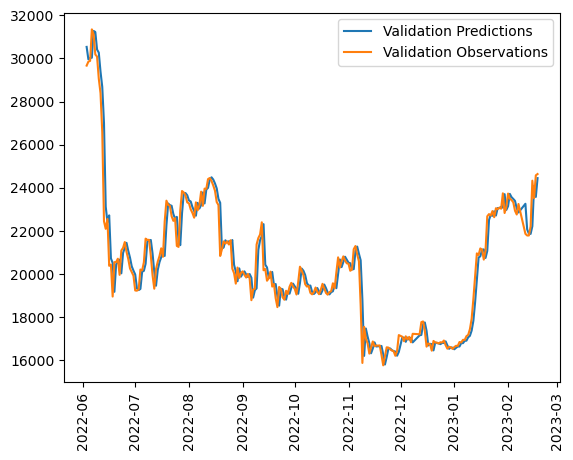

In [21]:
#Second model observations
val_predictions2 = model2.predict(X_val2).flatten()

plt.plot(dates_val2, np.exp(val_predictions2))
plt.plot(dates_val2, np.exp(y_val2))
plt.xticks(rotation=90)
plt.legend(['Validation Predictions', 'Validation Observations'])

In [22]:
#MSAE Score for second model
score = model2.evaluate(X_test2, y_test2, verbose = 0) 

print('Test loss:', score[0]) 
print('Test MAE:', score[1])

Test loss: 0.0005294777802191675
Test MAE: 0.01591518707573414


In [23]:
# R2 score for second model
y_pred = model2.predict(X_test2)
print('R2 Score: ', r2_score(y_test2, y_pred))

7/7 [==============================] - 0s 4ms/step
R2 Score:  0.9287120289619462


7/7 [==============================] - 0s 3ms/step


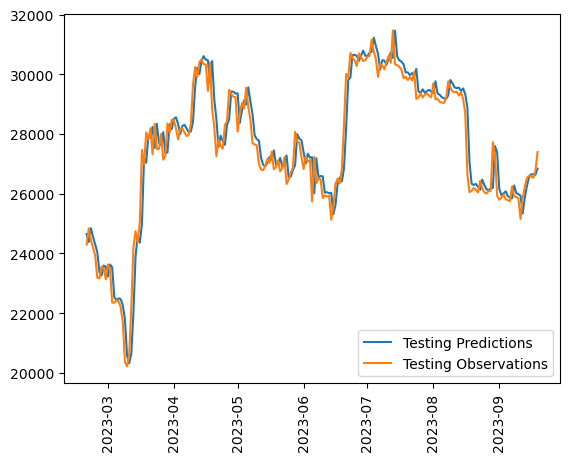

In [24]:
#Second model observations
test_predictions2 = model2.predict(X_test2).flatten()

plt.plot(dates_test2, np.exp(test_predictions2))
plt.plot(dates_test2,np.exp(y_test2))
plt.xticks(rotation=90)
plt.legend(['Testing Predictions', 'Testing Observations'])

In [25]:
# Second optimization. Increased neural density, epochs
model3 = Sequential([layers.Input((lookback, 1)),
                    layers.LSTM(64, return_sequences=True),
                    layers.LSTM(64, return_sequences=False),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(1)])

model3.compile(loss='mse',
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_error'])

model3.fit(X_train2, y_train2, validation_data=(X_val2, y_val2), epochs=300)

Epoch 1/300
52/52 [==============================] - 7s 43ms/step - loss: 35.3988 - mean_absolute_error: 4.9492 - val_loss: 0.5327 - val_mean_absolute_error: 0.7163
Epoch 2/300
52/52 [==============================] - 1s 12ms/step - loss: 0.9167 - mean_absolute_error: 0.8112 - val_loss: 0.1096 - val_mean_absolute_error: 0.3000
Epoch 3/300
52/52 [==============================] - 1s 12ms/step - loss: 0.7472 - mean_absolute_error: 0.7562 - val_loss: 0.1601 - val_mean_absolute_error: 0.3750
Epoch 4/300
52/52 [==============================] - 1s 11ms/step - loss: 0.7457 - mean_absolute_error: 0.7541 - val_loss: 0.2312 - val_mean_absolute_error: 0.4601
Epoch 5/300
52/52 [==============================] - 1s 11ms/step - loss: 0.7378 - mean_absolute_error: 0.7512 - val_loss: 0.1482 - val_mean_absolute_error: 0.3591
Epoch 6/300
52/52 [==============================] - 1s 10ms/step - loss: 0.7263 - mean_absolute_error: 0.7480 - val_loss: 0.1504 - val_mean_absolute_error: 0.3629
Epoch 7/300
52/

Epoch 51/300
52/52 [==============================] - 1s 10ms/step - loss: 0.0108 - mean_absolute_error: 0.0820 - val_loss: 0.0164 - val_mean_absolute_error: 0.1184
Epoch 52/300
52/52 [==============================] - 1s 10ms/step - loss: 0.0131 - mean_absolute_error: 0.0930 - val_loss: 0.0080 - val_mean_absolute_error: 0.0747
Epoch 53/300
52/52 [==============================] - 1s 10ms/step - loss: 0.0086 - mean_absolute_error: 0.0723 - val_loss: 0.0078 - val_mean_absolute_error: 0.0688
Epoch 54/300
52/52 [==============================] - 1s 10ms/step - loss: 0.0088 - mean_absolute_error: 0.0727 - val_loss: 0.0270 - val_mean_absolute_error: 0.1561
Epoch 55/300
52/52 [==============================] - 1s 10ms/step - loss: 0.0108 - mean_absolute_error: 0.0814 - val_loss: 0.0050 - val_mean_absolute_error: 0.0526
Epoch 56/300
52/52 [==============================] - 1s 10ms/step - loss: 0.0082 - mean_absolute_error: 0.0699 - val_loss: 0.0040 - val_mean_absolute_error: 0.0437
Epoch 57/3

Epoch 101/300
52/52 [==============================] - 1s 12ms/step - loss: 0.0081 - mean_absolute_error: 0.0710 - val_loss: 0.0051 - val_mean_absolute_error: 0.0578
Epoch 102/300
52/52 [==============================] - 1s 13ms/step - loss: 0.0060 - mean_absolute_error: 0.0589 - val_loss: 0.0080 - val_mean_absolute_error: 0.0734
Epoch 103/300
52/52 [==============================] - 1s 13ms/step - loss: 0.0081 - mean_absolute_error: 0.0697 - val_loss: 0.0053 - val_mean_absolute_error: 0.0606
Epoch 104/300
52/52 [==============================] - 1s 11ms/step - loss: 0.0070 - mean_absolute_error: 0.0651 - val_loss: 0.0048 - val_mean_absolute_error: 0.0562
Epoch 105/300
52/52 [==============================] - 1s 12ms/step - loss: 0.0063 - mean_absolute_error: 0.0607 - val_loss: 0.0038 - val_mean_absolute_error: 0.0406
Epoch 106/300
52/52 [==============================] - 1s 13ms/step - loss: 0.0067 - mean_absolute_error: 0.0641 - val_loss: 0.0126 - val_mean_absolute_error: 0.0978
Epoc

52/52 [==============================] - 1s 11ms/step - loss: 0.0037 - mean_absolute_error: 0.0455 - val_loss: 0.0024 - val_mean_absolute_error: 0.0328
Epoch 151/300
52/52 [==============================] - 1s 10ms/step - loss: 0.0042 - mean_absolute_error: 0.0490 - val_loss: 0.0026 - val_mean_absolute_error: 0.0400
Epoch 152/300
52/52 [==============================] - 1s 11ms/step - loss: 0.0047 - mean_absolute_error: 0.0531 - val_loss: 0.0024 - val_mean_absolute_error: 0.0348
Epoch 153/300
52/52 [==============================] - 1s 11ms/step - loss: 0.0041 - mean_absolute_error: 0.0486 - val_loss: 0.0037 - val_mean_absolute_error: 0.0472
Epoch 154/300
52/52 [==============================] - 1s 11ms/step - loss: 0.0040 - mean_absolute_error: 0.0478 - val_loss: 0.0024 - val_mean_absolute_error: 0.0341
Epoch 155/300
52/52 [==============================] - 1s 11ms/step - loss: 0.0053 - mean_absolute_error: 0.0567 - val_loss: 0.0026 - val_mean_absolute_error: 0.0364
Epoch 156/300
52/5

52/52 [==============================] - 1s 12ms/step - loss: 0.0047 - mean_absolute_error: 0.0535 - val_loss: 0.0021 - val_mean_absolute_error: 0.0376
Epoch 200/300
52/52 [==============================] - 1s 10ms/step - loss: 0.0035 - mean_absolute_error: 0.0461 - val_loss: 0.0015 - val_mean_absolute_error: 0.0280
Epoch 201/300
52/52 [==============================] - 1s 10ms/step - loss: 0.0028 - mean_absolute_error: 0.0394 - val_loss: 0.0021 - val_mean_absolute_error: 0.0366
Epoch 202/300
52/52 [==============================] - 1s 10ms/step - loss: 0.0048 - mean_absolute_error: 0.0546 - val_loss: 0.0059 - val_mean_absolute_error: 0.0686
Epoch 203/300
52/52 [==============================] - 1s 10ms/step - loss: 0.0035 - mean_absolute_error: 0.0456 - val_loss: 0.0033 - val_mean_absolute_error: 0.0476
Epoch 204/300
52/52 [==============================] - 1s 10ms/step - loss: 0.0029 - mean_absolute_error: 0.0400 - val_loss: 0.0032 - val_mean_absolute_error: 0.0467
Epoch 205/300
52/5

52/52 [==============================] - 1s 11ms/step - loss: 0.0025 - mean_absolute_error: 0.0376 - val_loss: 0.0051 - val_mean_absolute_error: 0.0638
Epoch 249/300
52/52 [==============================] - 1s 10ms/step - loss: 0.0025 - mean_absolute_error: 0.0376 - val_loss: 0.0013 - val_mean_absolute_error: 0.0249
Epoch 250/300
52/52 [==============================] - 1s 10ms/step - loss: 0.0035 - mean_absolute_error: 0.0463 - val_loss: 0.0060 - val_mean_absolute_error: 0.0705
Epoch 251/300
52/52 [==============================] - 1s 10ms/step - loss: 0.0038 - mean_absolute_error: 0.0471 - val_loss: 0.0013 - val_mean_absolute_error: 0.0247
Epoch 252/300
52/52 [==============================] - 1s 10ms/step - loss: 0.0030 - mean_absolute_error: 0.0414 - val_loss: 0.0016 - val_mean_absolute_error: 0.0293
Epoch 253/300
52/52 [==============================] - 1s 10ms/step - loss: 0.0036 - mean_absolute_error: 0.0468 - val_loss: 0.0013 - val_mean_absolute_error: 0.0253
Epoch 254/300
52/5

52/52 [==============================] - 1s 13ms/step - loss: 0.0027 - mean_absolute_error: 0.0396 - val_loss: 0.0025 - val_mean_absolute_error: 0.0428
Epoch 298/300
52/52 [==============================] - 1s 12ms/step - loss: 0.0025 - mean_absolute_error: 0.0375 - val_loss: 0.0011 - val_mean_absolute_error: 0.0212
Epoch 299/300
52/52 [==============================] - 1s 11ms/step - loss: 0.0026 - mean_absolute_error: 0.0377 - val_loss: 0.0017 - val_mean_absolute_error: 0.0322
Epoch 300/300
52/52 [==============================] - 1s 11ms/step - loss: 0.0025 - mean_absolute_error: 0.0369 - val_loss: 0.0034 - val_mean_absolute_error: 0.0502


52/52 [==============================] - 1s 4ms/step


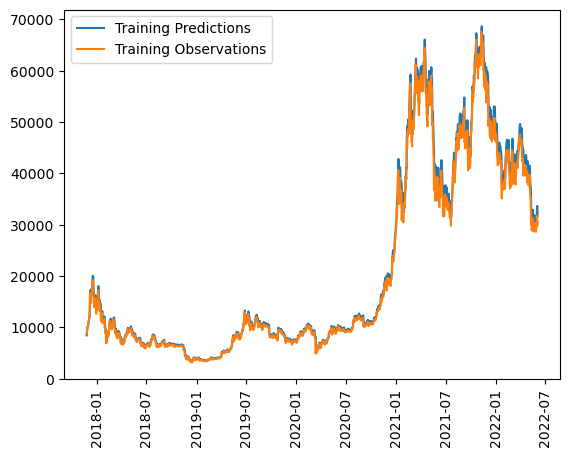

In [26]:
#Third model observations
train_predictions3 = model3.predict(X_train2).flatten()

plt.plot(dates_train2, np.exp(train_predictions3))
plt.plot(dates_train2, np.exp(y_train2))
plt.xticks(rotation=90)
plt.legend(['Training Predictions', 'Training Observations'])

In [27]:
score = model3.evaluate(X_val2, y_val2, verbose = 0) 

print('Val loss:', score[0]) 
print('Val MAE:', score[1])

Val loss: 0.0033780981320887804
Val MAE: 0.05018676072359085


8/8 [==============================] - 0s 4ms/step


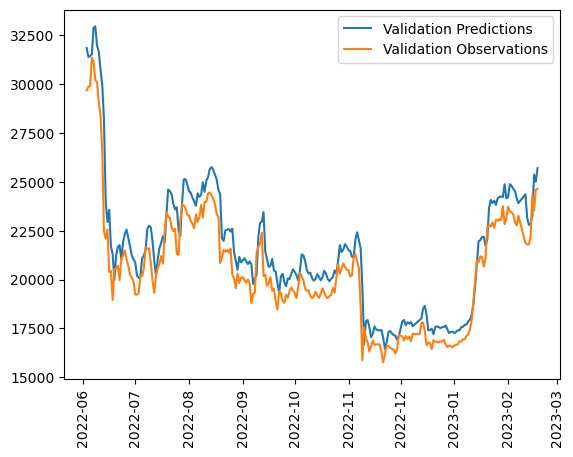

In [28]:
#Second model observations 
val_predictions3 = model3.predict(X_val2).flatten()

plt.plot(dates_val2, np.exp(val_predictions3))
plt.plot(dates_val2, np.exp(y_val2))
plt.xticks(rotation=90)
plt.legend(['Validation Predictions', 'Validation Observations'])

In [29]:
# Third Model MAE score
score = model3.evaluate(X_test2, y_test2, verbose = 0) 

print('Test loss:', score[0]) 
print('Test MAE:', score[1])

Test loss: 0.0031596627086400986
Test MAE: 0.05282974615693092


7/7 [==============================] - 0s 4ms/step


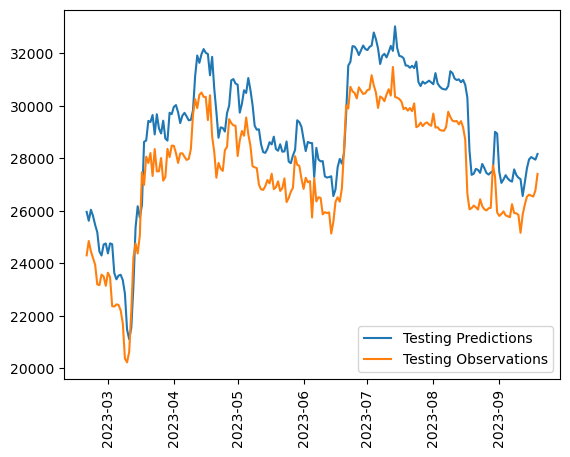

In [30]:
test_predictions3 = model3.predict(X_test2).flatten()

plt.plot(dates_test2, np.exp(test_predictions3))
plt.plot(dates_test2,np.exp(y_test2))
plt.xticks(rotation=90)
plt.legend(['Testing Predictions', 'Testing Observations'])

In [31]:
# R2 score for second model

print('R2 Score: ', r2_score(y_test2, test_predictions3))

R2 Score:  0.5745873588776444


## Future Prediction
- Attempting to look ahead x days in an attempt to predict upcoming trends

In [42]:
# Initialize an array to store predictions
predictions = []
predicted_dates = []
prediction_range = 7

#create list of numbers to add to date based on date range
date_range = list(range(1, prediction_range +1))

# Use the last n_steps data points from the training set to make predictions
current_batch = X_test2[-1]
current_reshape = current_batch.reshape((1, lookback, 1))
initial_date = dates_test2[-1]

# Generate predictions for 7 days
for i in range(prediction_range): # Generate predictions for 7 days
    # Predict the next data point
    current_pred = model.predict(current_reshape)[0,0]
    
    # Append the prediction to the list of predictions
    predictions.append(current_pred)
        

    # Update initial input for the next step
    updated_batch = np.insert(current_batch, -1, current_pred)
    
    #resize batch 
    current_batch = updated_batch[1:]
    
    #reshape batch
    current_reshape = current_batch.reshape((1, lookback, 1))

    
for day in date_range:
    new_date = initial_date + dt.timedelta(days=day)
    predicted_dates.append(new_date
                          )
# 'predictions' contains 7-day forecast
print(predictions)

for date in predicted_dates:
    print(date)

1/1 [==============================] - 0s 22ms/step
[10.171644, 10.1700535, 10.170402, 10.170566, 10.1704855, 10.170428, 10.170444]
2023-09-20
2023-09-21
2023-09-22
2023-09-23
2023-09-24
2023-09-25
2023-09-26


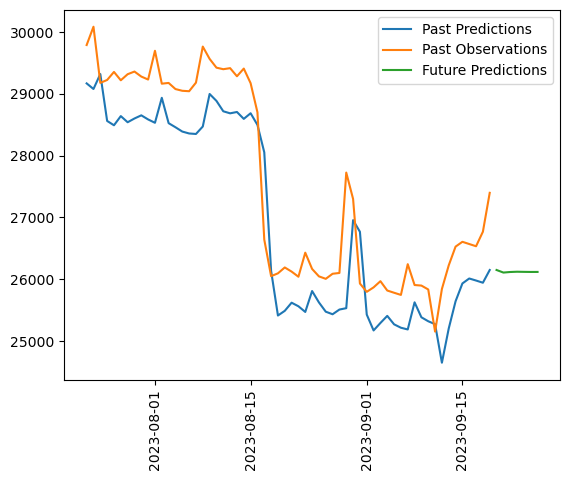

In [44]:
#Plot last 60 days of testing plus future prediction
plt.plot(dates_test2[-60:], np.exp(test_predictions[-60:]))
plt.plot(dates_test2[-60:],np.exp(y_test2[-60:]))
plt.plot(predicted_dates, np.exp(predictions))
plt.xticks(rotation=90)
plt.legend(['Past Predictions', 'Past Observations','Future Predictions'])

In [45]:
# Export model1 to HDF5 file
model.save("H5_Files/btc_7_day_1.h5")

In [46]:
# Export model2 to HDF5 file
model2.save("H5_Files/btc_7_day_2.h5")

In [47]:
# Export model to HDF5 file
model3.save("H5_Files/btc_7_day_3.h5")

In [48]:
# build output into a df for graphing in js

df = pd.DataFrame({"Date": dates_test2[-90:], "observed":np.exp(y_test2[-90:]),\
                "model_1_predicted":np.exp(test_predictions[-90:]),\
                "model_2_predicted":np.exp(test_predictions2[-90:]),\
                "model_3_predicted":np.exp(test_predictions3[-90:])})
df.set_index('Date', inplace=True)

# df2 = pd.DataFrame({"Date": predicted_dates, "future_prediction":np.exp(predictions)})
# df2.set_index('Date', inplace=True)                   
                    
# past_future_df = pd.merge(df,df2, how='outer', left_index=True, right_index=True)


df


,observed,model_1_predicted,model_2_predicted,model_3_predicted
Date,,,,
2023-06-21,30009.0,27549.787109,28197.410156,29664.820312
2023-06-22,29889.0,29185.976562,29805.417969,31521.050781
2023-06-23,30716.0,29220.707031,29893.291016,31665.279297
2023-06-24,30548.0,29862.205078,30644.216797,32265.720703
2023-06-25,30477.0,29819.632812,30651.496094,32248.615234
...,...,...,...,...
2023-09-15,26607.0,25933.207031,26551.841797,27949.388672
2023-09-16,26571.0,26013.660156,26652.683594,28039.359375
2023-09-17,26535.0,25980.488281,26647.779297,27991.320312


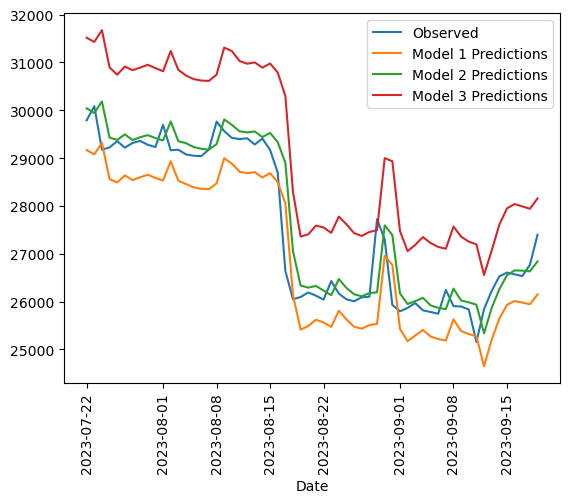

In [49]:
#Measuring each model's predictions against the test data
df[-60:].plot(use_index=True)
plt.xticks(rotation=90)

plt.legend(['Observed', 'Model 1 Predictions', 'Model 2 Predictions', \
            'Model 3 Predictions'])
plt.show()

In [50]:
#output prediction data to csv
df.to_csv('output/btc_predict.csv') 

In [51]:
#output original historical data to csv
data.to_csv('output/btc_lifetime.csv')

In [52]:
#Scores for each model

print('Model 1 R2 Score: ', r2_score(y_test1, test_predictions))
print('Model 2 R2 Score: ', r2_score(y_test2, test_predictions2))
print('Model 3 R2 Score: ', r2_score(y_test2, test_predictions3))

Model 1 R2 Score:  0.9687440959825682
Model 2 R2 Score:  0.9287120289619462
Model 3 R2 Score:  0.5745873588776444
